## Lab 1 
Giovanni Santos - 22523
Mauricio Lemus

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

Importing plotly failed. Interactive plots will not work.


## Analisis 1: Daily total female births

In [2]:
df = pd.read_csv('daily-total-female-births.csv', parse_dates=['Date'], index_col='Date')
print("Datos cargados exitosamente!")
print(f"Forma del dataset: {df.shape}")
print(f"Rango de fechas: {df.index.min()} a {df.index.max()}")
print("\nPrimeras 5 observaciones:")
print(df.head())
print("\nEstadísticas descriptivas:")
print(df.describe())


Datos cargados exitosamente!
Forma del dataset: (365, 1)
Rango de fechas: 1959-01-01 00:00:00 a 1959-12-31 00:00:00

Primeras 5 observaciones:
            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44

Estadísticas descriptivas:
           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000



2. ANÁLISIS EXPLORATORIO


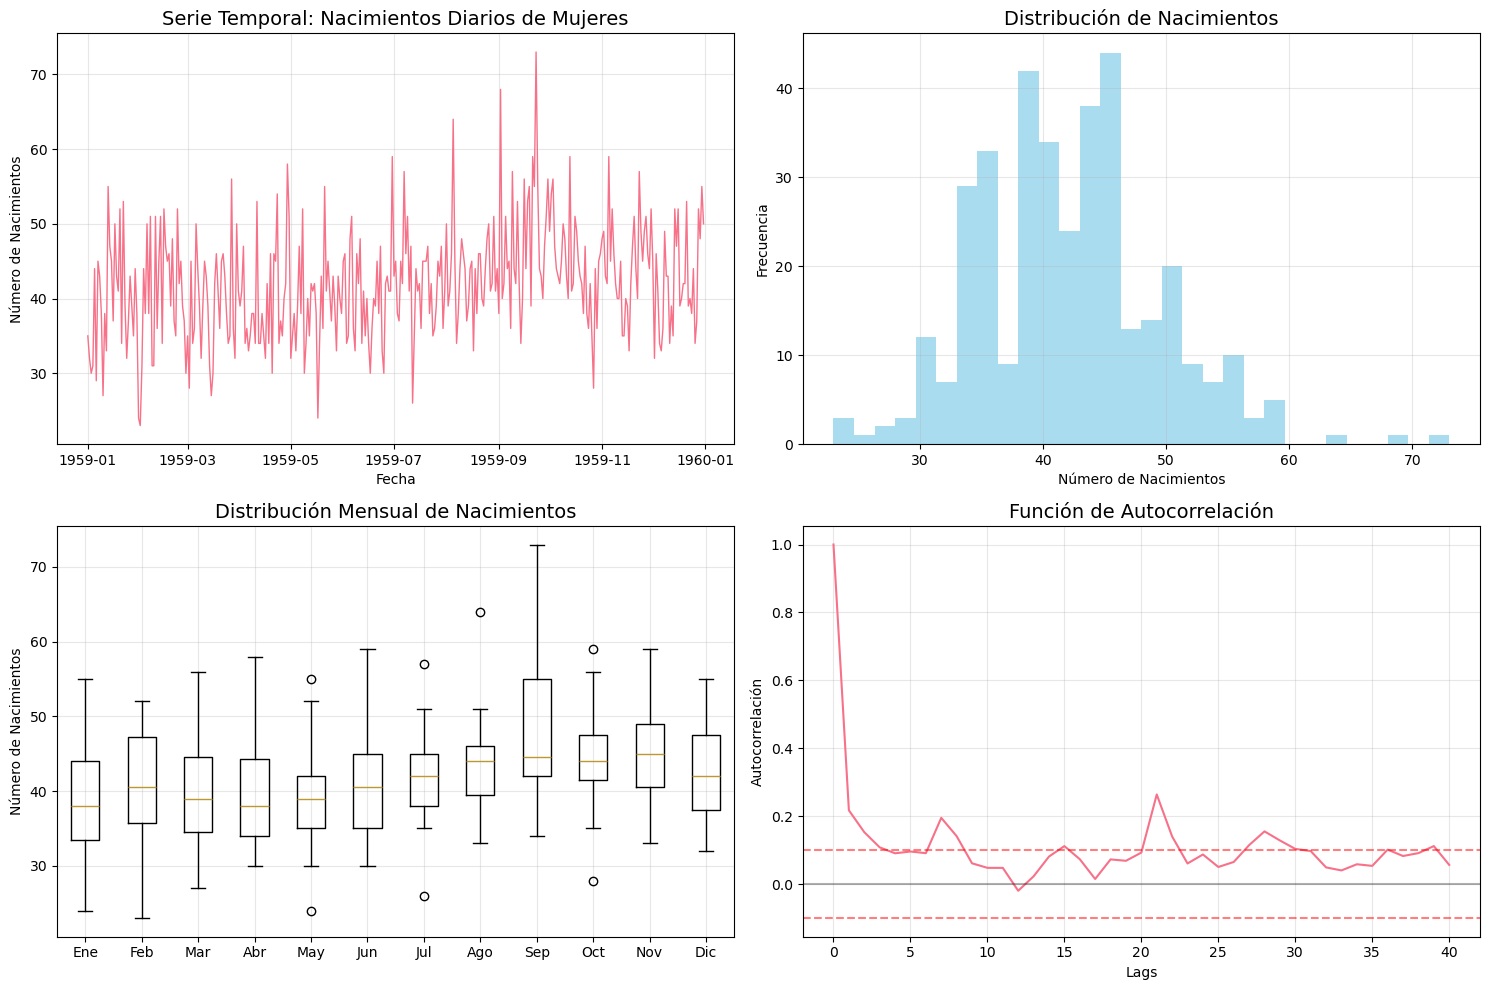

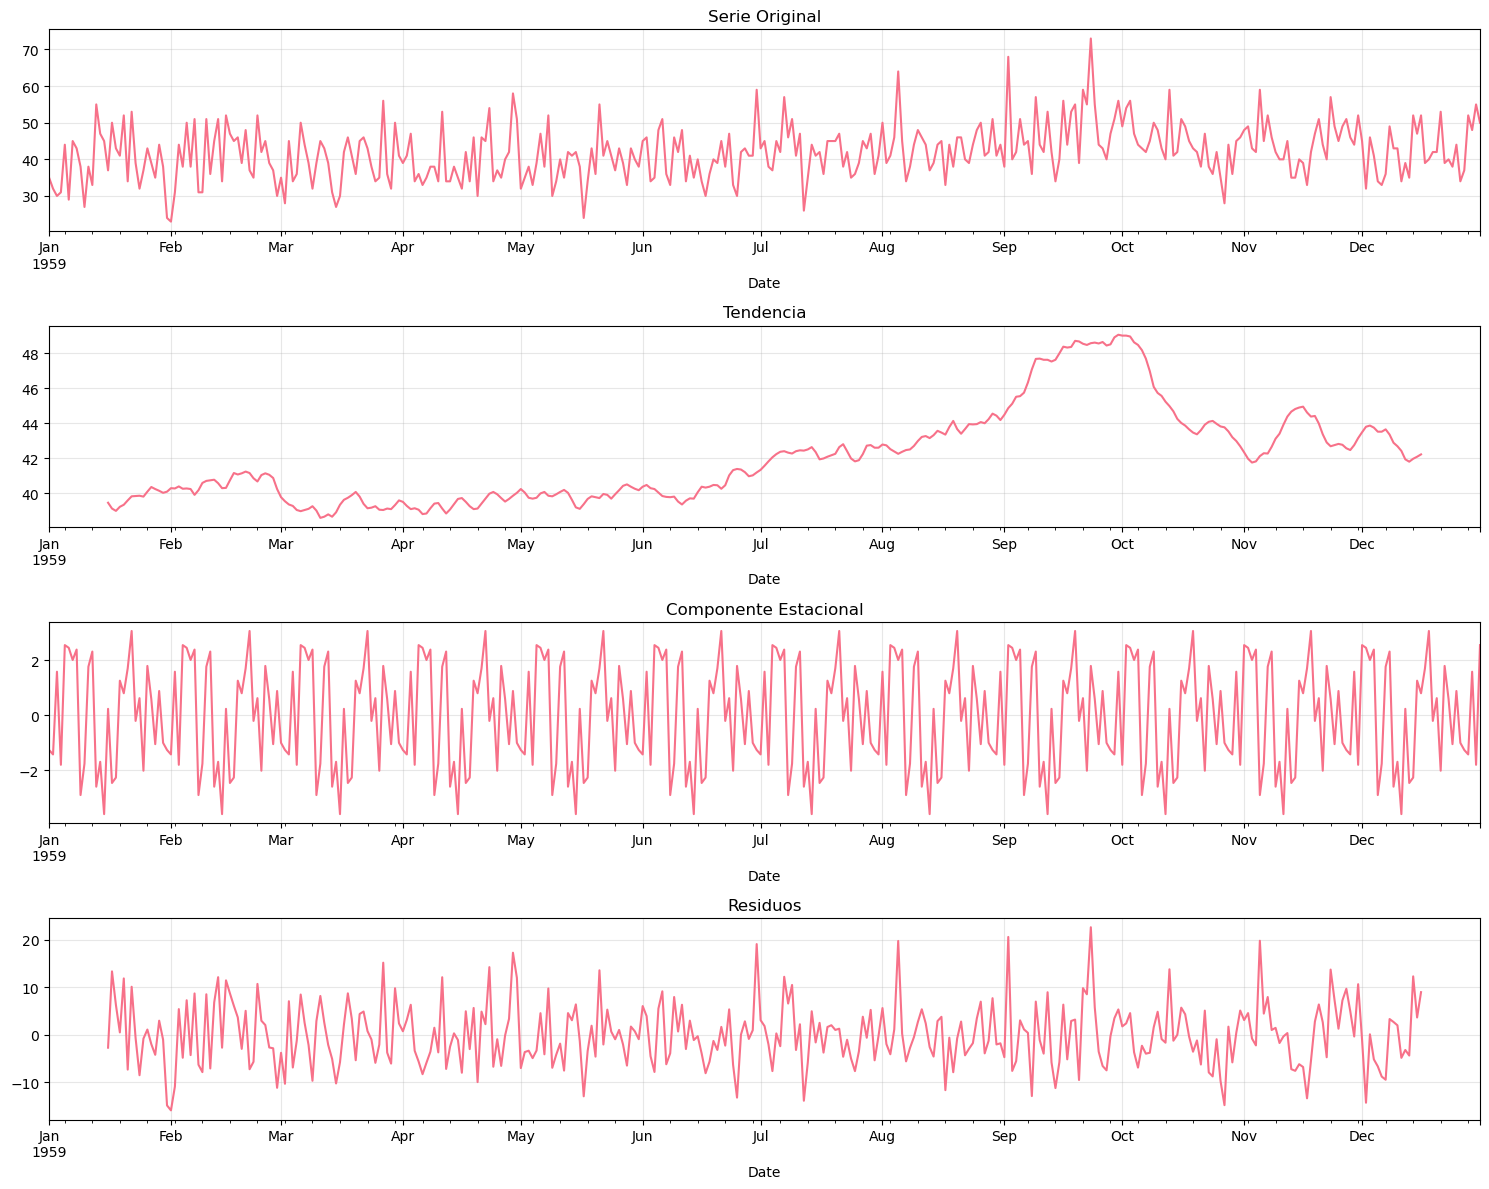


Test de Estacionariedad (ADF):
Estadístico ADF: -4.808291
p-valor: 0.000052
Valores críticos:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Serie estacionaria (rechazamos H0)


In [3]:
print("\n" + "=" * 50)
print("2. ANÁLISIS EXPLORATORIO")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(df.index, df['Births'], linewidth=1)
axes[0,0].set_title('Serie Temporal: Nacimientos Diarios de Mujeres', fontsize=14)
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Número de Nacimientos')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(df['Births'], bins=30, alpha=0.7, color='skyblue')
axes[0,1].set_title('Distribución de Nacimientos', fontsize=14)
axes[0,1].set_xlabel('Número de Nacimientos')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(True, alpha=0.3)

df_monthly = df.copy()
df_monthly['Month'] = df_monthly.index.month
monthly_data = [df_monthly[df_monthly['Month'] == i]['Births'] for i in range(1, 13)]
axes[1,0].boxplot(monthly_data, labels=['Ene','Feb','Mar','Abr','May','Jun',
                                       'Jul','Ago','Sep','Oct','Nov','Dic'])
axes[1,0].set_title('Distribución Mensual de Nacimientos', fontsize=14)
axes[1,0].set_ylabel('Número de Nacimientos')
axes[1,0].grid(True, alpha=0.3)

from statsmodels.tsa.stattools import acf
lags = 40
autocorr = acf(df['Births'], nlags=lags)
axes[1,1].plot(range(lags+1), autocorr)
axes[1,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,1].axhline(y=0.1, color='r', linestyle='--', alpha=0.5)
axes[1,1].axhline(y=-0.1, color='r', linestyle='--', alpha=0.5)
axes[1,1].set_title('Función de Autocorrelación', fontsize=14)
axes[1,1].set_xlabel('Lags')
axes[1,1].set_ylabel('Autocorrelación')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

decomposition = seasonal_decompose(df['Births'], model='additive', period=30)
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Serie Original')
decomposition.trend.plot(ax=axes[1], title='Tendencia')
decomposition.seasonal.plot(ax=axes[2], title='Componente Estacional')
decomposition.resid.plot(ax=axes[3], title='Residuos')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

def adf_test(timeseries, title):
    result = adfuller(timeseries.dropna())
    print(f'\n{title}:')
    print(f'Estadístico ADF: {result[0]:.6f}')
    print(f'p-valor: {result[1]:.6f}')
    print(f'Valores críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Serie estacionaria (rechazamos H0)")
    else:
        print("Serie no estacionaria (no rechazamos H0)")

adf_test(df['Births'], 'Test de Estacionariedad (ADF)')



3. DIVISIÓN DE DATOS
Datos de entrenamiento: 292 observaciones
Datos de prueba: 73 observaciones


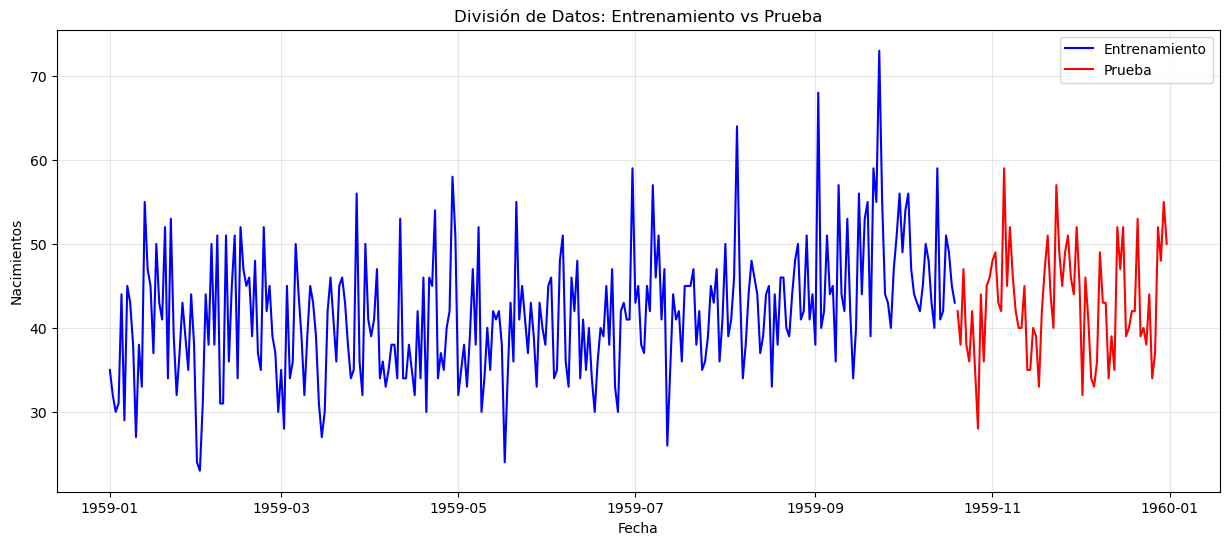

In [4]:
print("\n" + "=" * 50)
print("3. DIVISIÓN DE DATOS")
print("=" * 50)

train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

print(f"Datos de entrenamiento: {len(train_data)} observaciones")
print(f"Datos de prueba: {len(test_data)} observaciones")

plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['Births'], label='Entrenamiento', color='blue')
plt.plot(test_data.index, test_data['Births'], label='Prueba', color='red')
plt.title('División de Datos: Entrenamiento vs Prueba')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


4. PROMEDIOS MÓVILES


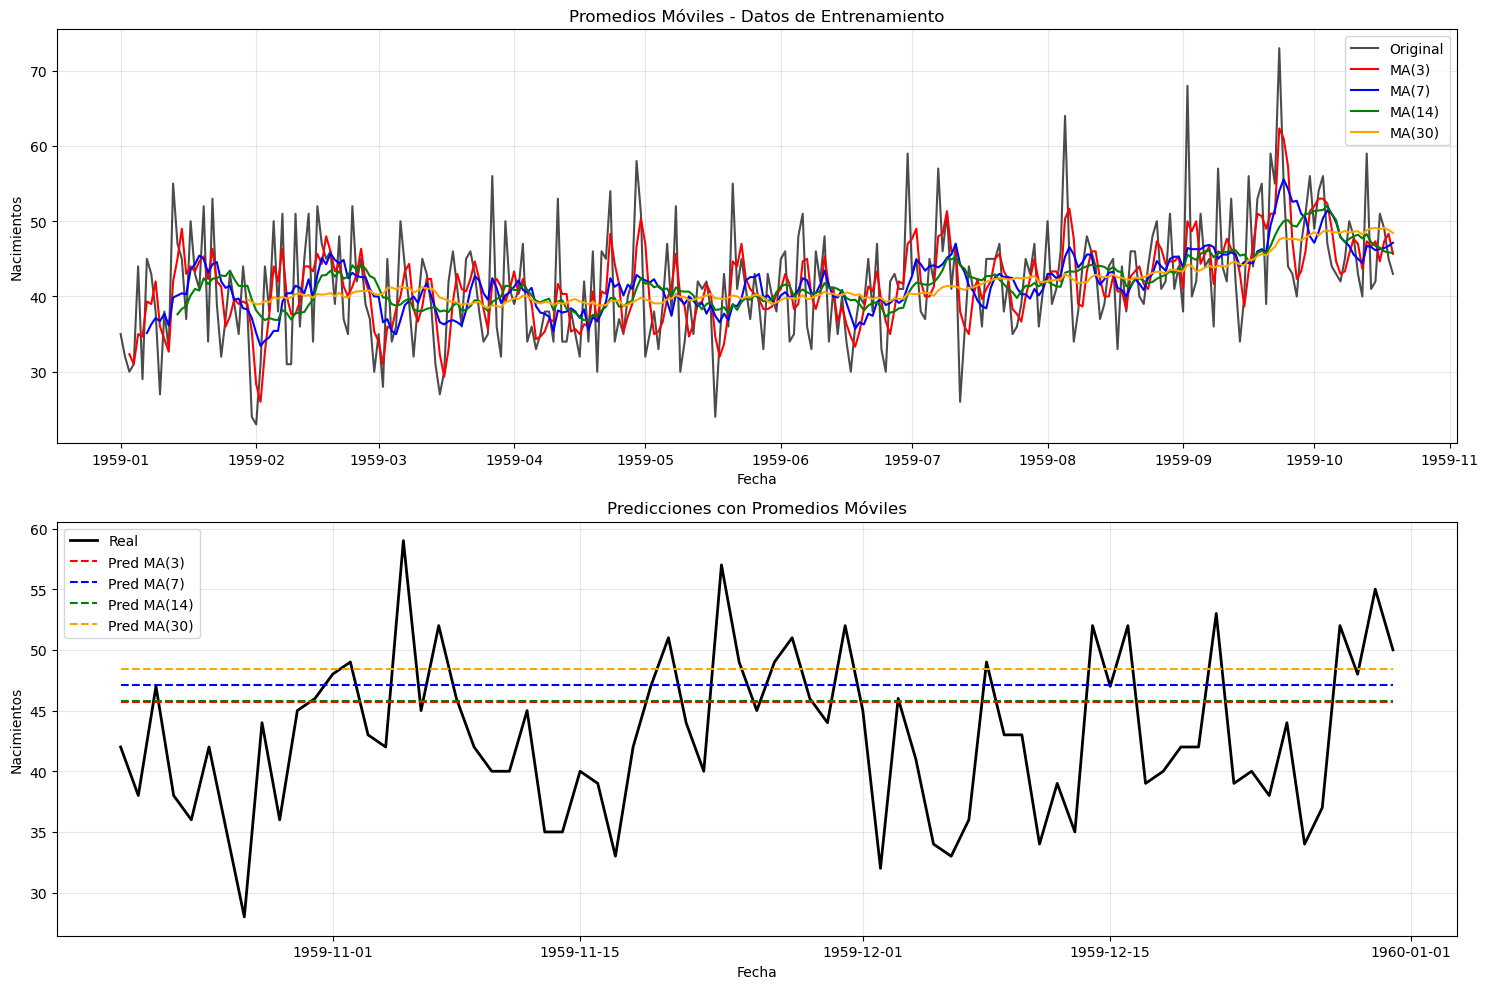

In [5]:

print("\n" + "=" * 50)
print("4. PROMEDIOS MÓVILES")
print("=" * 50)

windows = [3, 7, 14, 30]
ma_predictions = {}

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Births'], label='Original', color='black', alpha=0.7)

colors = ['red', 'blue', 'green', 'orange']
for i, window in enumerate(windows):
    ma = train_data['Births'].rolling(window=window).mean()
    plt.plot(train_data.index, ma, label=f'MA({window})', color=colors[i])
    
    last_values = train_data['Births'].tail(window).values
    ma_pred = np.full(len(test_data), np.mean(last_values))
    ma_predictions[f'MA_{window}'] = ma_pred

plt.title('Promedios Móviles - Datos de Entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(test_data.index, test_data['Births'], label='Real', color='black', linewidth=2)

for i, window in enumerate(windows):
    plt.plot(test_data.index, ma_predictions[f'MA_{window}'], 
             label=f'Pred MA({window})', color=colors[i], linestyle='--')

plt.title('Predicciones con Promedios Móviles')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



5. ALISAMIENTO EXPONENCIAL SIMPLE


/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


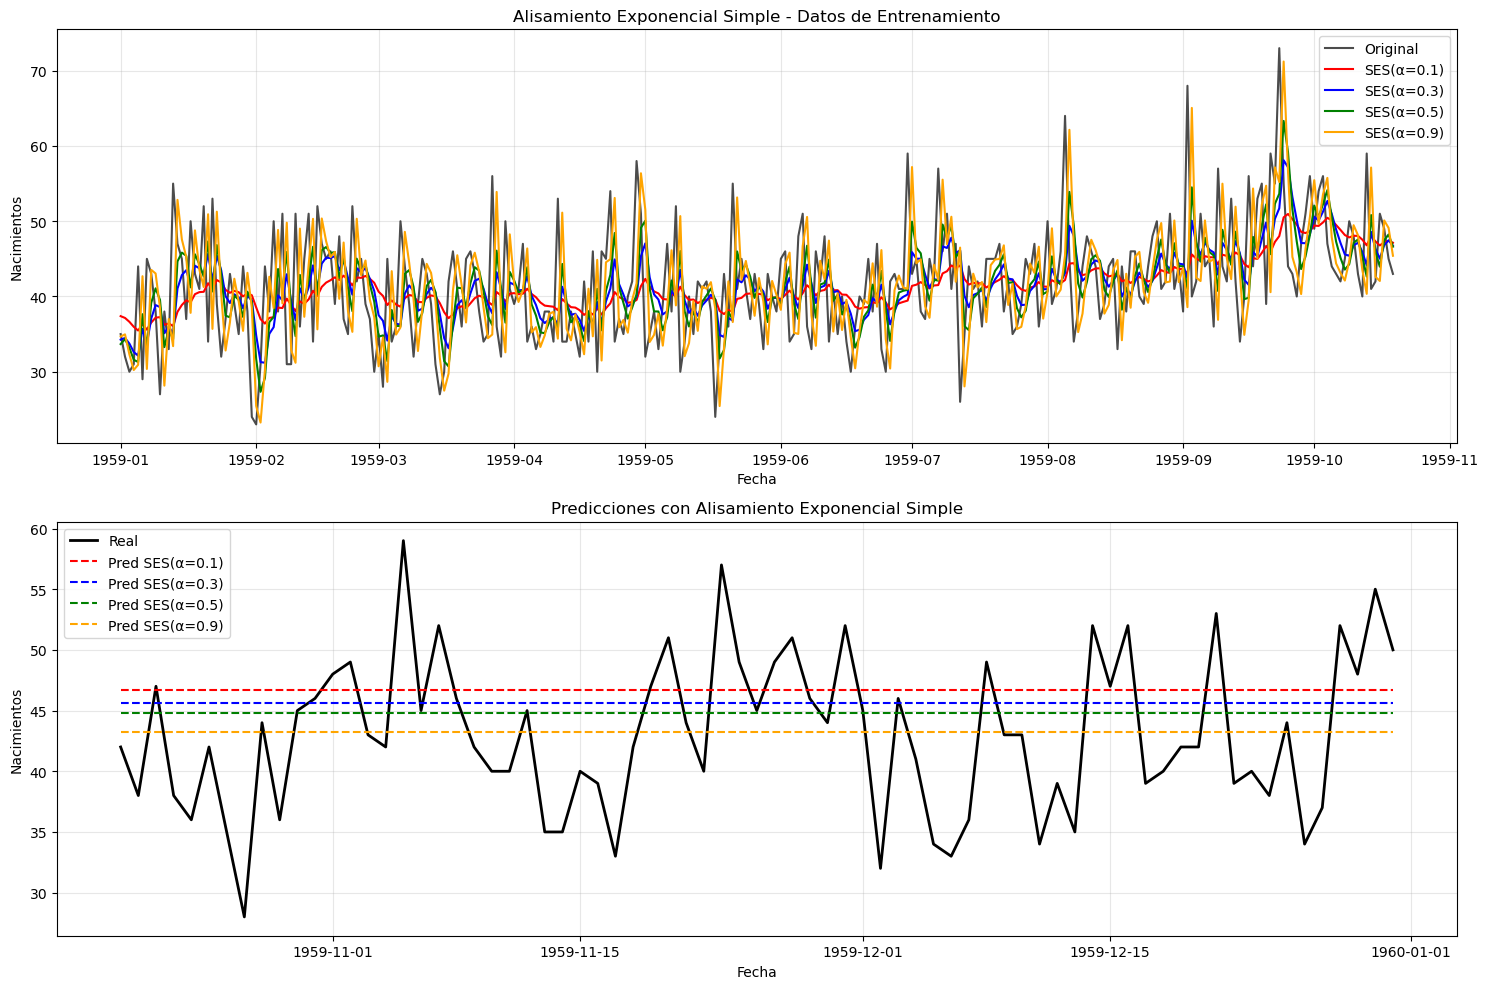

In [6]:

print("\n" + "=" * 50)
print("5. ALISAMIENTO EXPONENCIAL SIMPLE")
print("=" * 50)

alphas = [0.1, 0.3, 0.5, 0.9]
ses_predictions = {}

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Births'], label='Original', color='black', alpha=0.7)

colors = ['red', 'blue', 'green', 'orange']
for i, alpha in enumerate(alphas):
    ses_model = ExponentialSmoothing(train_data['Births'], trend=None, seasonal=None)
    ses_fit = ses_model.fit(smoothing_level=alpha)
    ses_forecast = ses_fit.fittedvalues
    
    plt.plot(train_data.index, ses_forecast, label=f'SES(α={alpha})', color=colors[i])
    
    ses_pred = ses_fit.forecast(steps=len(test_data))
    ses_predictions[f'SES_{alpha}'] = ses_pred

plt.title('Alisamiento Exponencial Simple - Datos de Entrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(test_data.index, test_data['Births'], label='Real', color='black', linewidth=2)

for i, alpha in enumerate(alphas):
    plt.plot(test_data.index, ses_predictions[f'SES_{alpha}'], 
             label=f'Pred SES(α={alpha})', color=colors[i], linestyle='--')

plt.title('Predicciones con Alisamiento Exponencial Simple')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



6. HOLT-WINTERS
Modelo Holt ajustado exitosamente
 Modelo Holt-Winters Aditivo ajustado exitosamente
Modelo Holt-Winters Multiplicativo ajustado exitosamente


/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


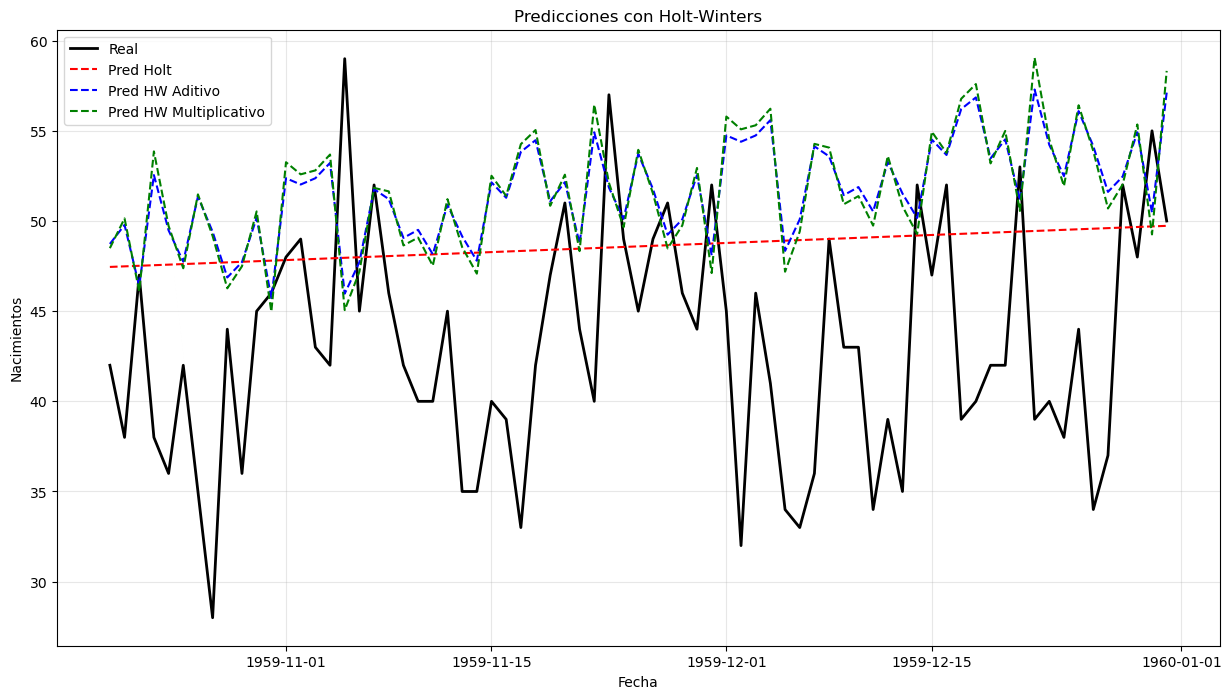

In [7]:

print("\n" + "=" * 50)
print("6. HOLT-WINTERS")
print("=" * 50)

hw_predictions = {}

try:
    holt_model = ExponentialSmoothing(train_data['Births'], trend='add', seasonal=None)
    holt_fit = holt_model.fit()
    holt_pred = holt_fit.forecast(steps=len(test_data))
    hw_predictions['Holt'] = holt_pred
    print("Modelo Holt ajustado exitosamente")
except:
    print("Error al ajustar modelo Holt")
    hw_predictions['Holt'] = np.full(len(test_data), train_data['Births'].mean())

try:
    hw_add_model = ExponentialSmoothing(train_data['Births'], trend='add', seasonal='add', seasonal_periods=30)
    hw_add_fit = hw_add_model.fit()
    hw_add_pred = hw_add_fit.forecast(steps=len(test_data))
    hw_predictions['HW_Add'] = hw_add_pred
    print(" Modelo Holt-Winters Aditivo ajustado exitosamente")
except:
    print("Error al ajustar modelo Holt-Winters Aditivo")
    hw_predictions['HW_Add'] = np.full(len(test_data), train_data['Births'].mean())

try:
    hw_mul_model = ExponentialSmoothing(train_data['Births'], trend='add', seasonal='mul', seasonal_periods=30)
    hw_mul_fit = hw_mul_model.fit()
    hw_mul_pred = hw_mul_fit.forecast(steps=len(test_data))
    hw_predictions['HW_Mul'] = hw_mul_pred
    print("Modelo Holt-Winters Multiplicativo ajustado exitosamente")
except:
    print("Error al ajustar modelo Holt-Winters Multiplicativo")
    hw_predictions['HW_Mul'] = np.full(len(test_data), train_data['Births'].mean())

plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data['Births'], label='Real', color='black', linewidth=2)

colors = ['red', 'blue', 'green']
labels = ['Holt', 'HW Aditivo', 'HW Multiplicativo']
for i, (key, pred) in enumerate(hw_predictions.items()):
    plt.plot(test_data.index, pred, label=f'Pred {labels[i]}', 
             color=colors[i], linestyle='--')

plt.title('Predicciones con Holt-Winters')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



7. MODELO SARIMA
Buscando mejores parámetros SARIMA...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=1981.644, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2140.816, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2073.296, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=1975.320, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2138.818, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=1974.613, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=1975.235, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=1976.995, Time=0.81 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=1974.959, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=1975.012, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=2071.359, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=1976.941, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[30]             : AIC=1975.608, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0

/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/soporte/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


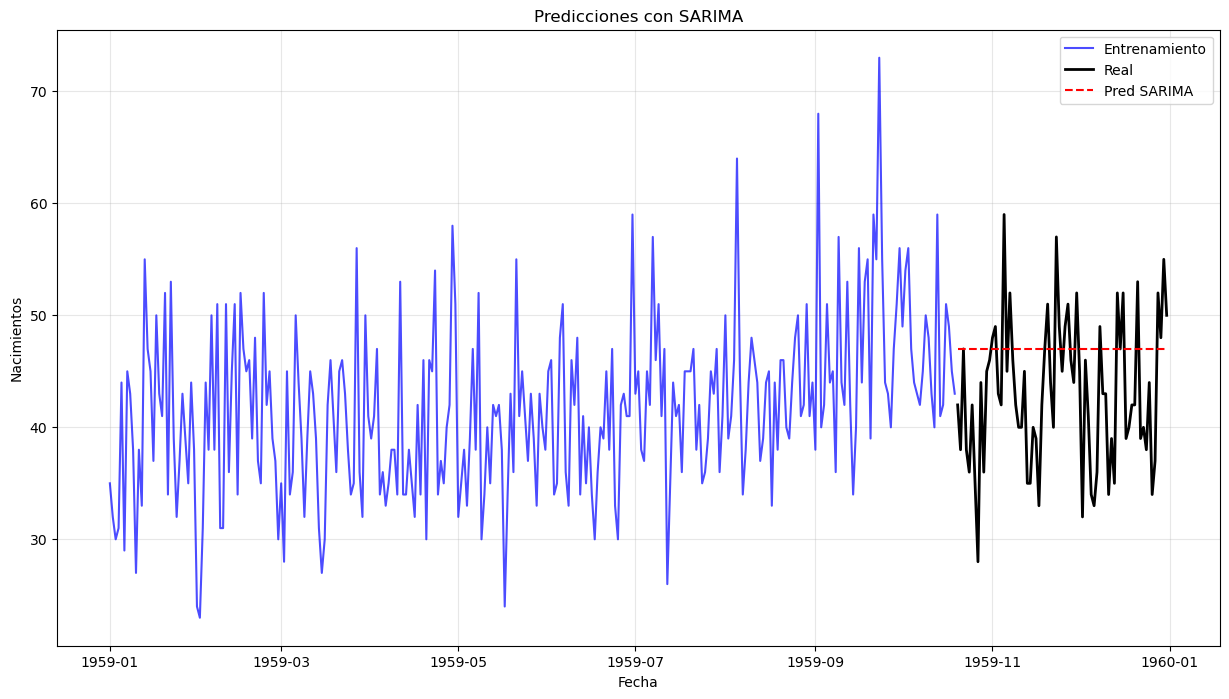

In [8]:
print("\n" + "=" * 50)
print("7. MODELO SARIMA")
print("=" * 50)

try:
    print("Buscando mejores parámetros SARIMA...")
    auto_model = auto_arima(train_data['Births'], 
                           seasonal=True, 
                           m=30,  
                           max_p=3, max_q=3, max_P=2, max_Q=2,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    
    print(f"Mejor modelo: {auto_model.order} x {auto_model.seasonal_order}")
    
    sarima_model = SARIMAX(train_data['Births'], 
                          order=auto_model.order,
                          seasonal_order=auto_model.seasonal_order)
    sarima_fit = sarima_model.fit(disp=False)
    
    sarima_pred = sarima_fit.forecast(steps=len(test_data))
    
    print("Modelo SARIMA ajustado exitosamente")
    
except Exception as e:
    print(f"Error con auto_arima: {e}")
    print("Usando parámetros por defecto...")
    
    try:
        sarima_model = SARIMAX(train_data['Births'], order=(1,1,1), seasonal_order=(1,1,1,30))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.forecast(steps=len(test_data))
        print("Modelo SARIMA con parámetros por defecto ajustado")
    except:
        print("Error al ajustar SARIMA")
        sarima_pred = np.full(len(test_data), train_data['Births'].mean())

plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data['Births'], label='Entrenamiento', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data['Births'], label='Real', color='black', linewidth=2)
plt.plot(test_data.index, sarima_pred, label='Pred SARIMA', color='red', linestyle='--')
plt.title('Predicciones con SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


9. COMPARACIÓN Y EVALUACIÓN DE MODELOS
RESULTADOS DE EVALUACIÓN:
 Modelo   RMSE   MAE   MAPE
SES_0.3  6.923 5.672 14.342
 SARIMA  7.557 6.224 15.990
   MA_7  7.629 6.292 16.179
   Holt  8.472 6.958 18.083
 HW_Add 11.185 9.511 24.427
 HW_Mul 11.343 9.679 24.754


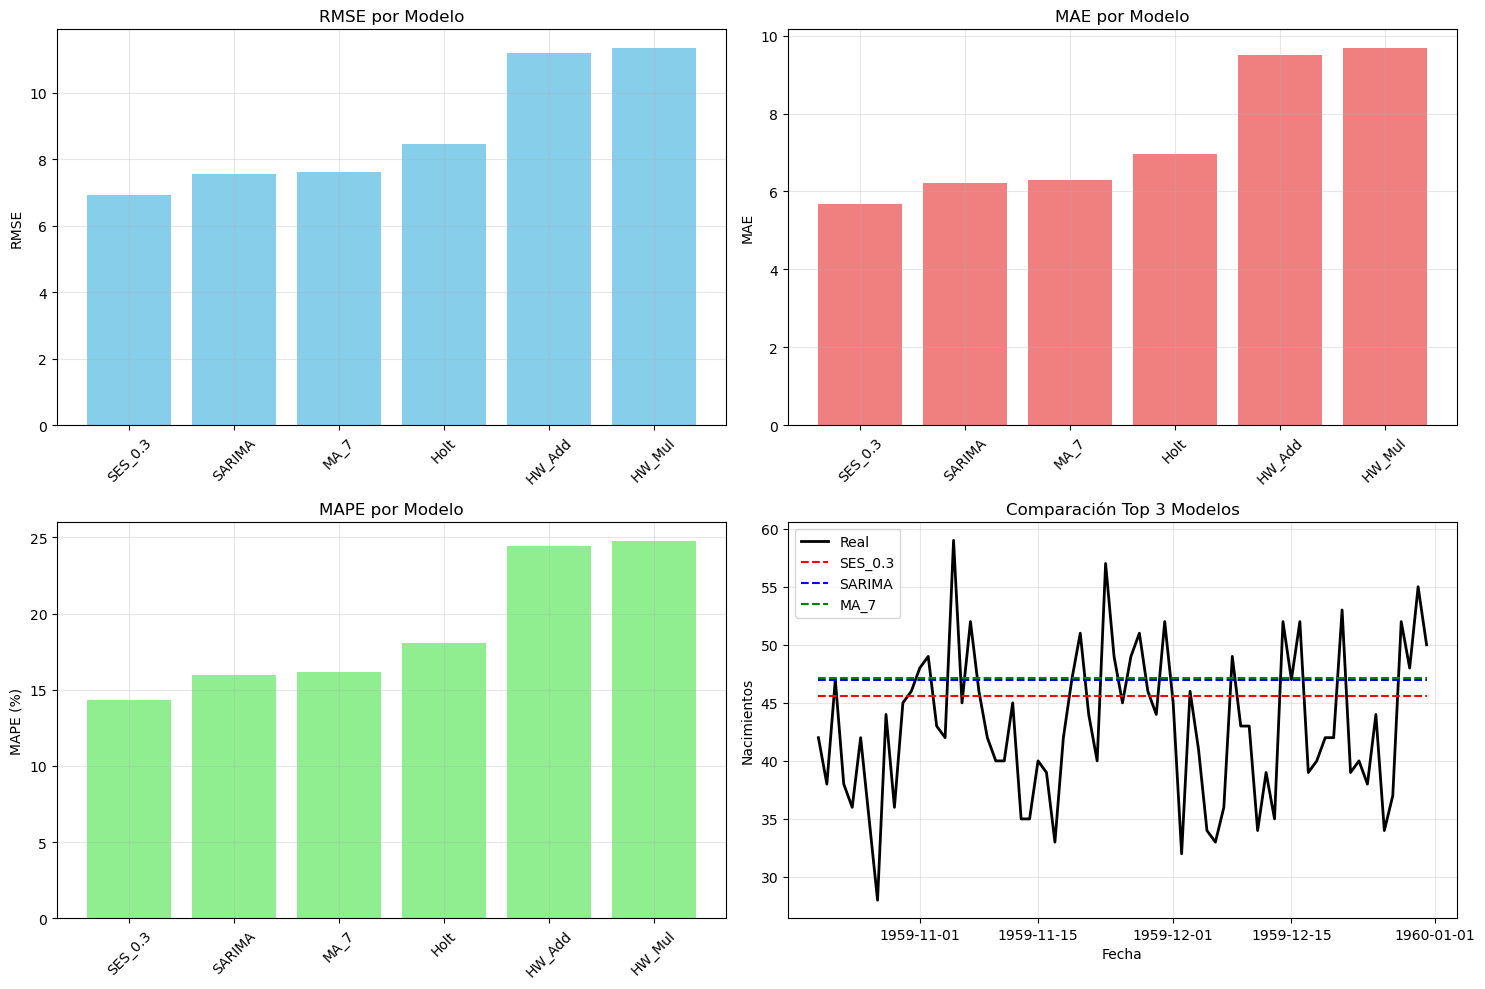

In [10]:
print("\n" + "=" * 50)
print("9. COMPARACIÓN Y EVALUACIÓN DE MODELOS")
print("=" * 50)

def calculate_metrics(actual, predicted, model_name):
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {
        'Modelo': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

all_predictions = {}

all_predictions['MA_7'] = ma_predictions['MA_7']

all_predictions['SES_0.3'] = ses_predictions['SES_0.3']

all_predictions.update(hw_predictions)

all_predictions['SARIMA'] = sarima_pred

results = []
actual_values = test_data['Births'].values

for model_name, predictions in all_predictions.items():
    try:
        metrics = calculate_metrics(actual_values, predictions, model_name)
        results.append(metrics)
    except:
        print(f"Error calculando métricas para {model_name}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("RESULTADOS DE EVALUACIÓN:")
print("=" * 60)
print(results_df.to_string(index=False, float_format='%.3f'))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.bar(results_df['Modelo'], results_df['RMSE'], color='skyblue')
plt.title('RMSE por Modelo')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.bar(results_df['Modelo'], results_df['MAE'], color='lightcoral')
plt.title('MAE por Modelo')
plt.xticks(rotation=45)
plt.ylabel('MAE')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.bar(results_df['Modelo'], results_df['MAPE'], color='lightgreen')
plt.title('MAPE por Modelo')
plt.xticks(rotation=45)
plt.ylabel('MAPE (%)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(test_data.index, actual_values, label='Real', color='black', linewidth=2)

top_3_models = results_df.head(3)['Modelo'].tolist()
colors = ['red', 'blue', 'green']

for i, model in enumerate(top_3_models):
    if model in all_predictions:
        plt.plot(test_data.index, all_predictions[model], 
                label=f'{model}', color=colors[i], linestyle='--')

plt.title('Comparación Top 3 Modelos')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()